In [1]:
# ----------------------------------------------------
# Step 1: Import required libraries
# ----------------------------------------------------
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Load the real dependency dataset
file_path = "/Users/chiaramarzovilla/Downloads/top_5000_npm_packages.csv"

df = pd.read_csv(file_path)
print("✅ File loaded successfully!")
print("Columns:", df.columns)
print(df.head())


✅ File loaded successfully!
Columns: Index(['package_name', 'description', 'installation_command', 'latest_version',
       'last_published', 'dependents', 'dependencies', 'versions', 'license',
       'total_files', 'unpacked_size', 'weekly_downloads', 'package_url',
       'homepage', 'repository', 'dependencies_list', 'devDependencies_list'],
      dtype='object')
     package_name                                        description  \
0     ansi-styles  ANSI escape codes for styling strings in the t...   
1  supports-color          Detect whether a terminal supports color.   
2          semver          The semantic version parser used by npm..   
3           chalk                Terminal string styling done right.   
4           debug  Lightweight debugging utility for Node.js and ...   

   installation_command latest_version last_published  dependents  \
0     npm i ansi-styles          6.2.1    2 years ago        3635   
1  npm i supports-color          9.4.0     a year ago      

In [3]:
import ast  # helps convert stringified lists back into Python lists

# ----------------------------------------------------
# Step 2: Build a directed graph of dependencies
# ----------------------------------------------------

# Clean and parse the dependencies_list column
# (It’s likely stored as a string like "['dep1', 'dep2']" instead of a real list)
df["dependencies_list"] = df["dependencies_list"].fillna("[]").apply(ast.literal_eval)

# Build a list of (package, dependency) pairs
edges = []
for _, row in df.iterrows():
    pkg = row["package_name"]
    for dep in row["dependencies_list"]:
        edges.append((pkg, dep))

# Create a directed graph from these edges
G = nx.DiGraph()
G.add_edges_from(edges)

print(f"✅ Dependency graph built: {G.number_of_nodes()} packages, {G.number_of_edges()} dependency edges.")


✅ Dependency graph built: 5423 packages, 12602 dependency edges.


In [5]:
# ----------------------------------------------------
# Step 3: Compute Transitivity Reach (Blast Radius)
# ----------------------------------------------------

# Reverse the graph so edges point "who depends on me"
revG = G.reverse(copy=True)

# For each package, count how many others depend (directly or indirectly) on it
transitivity_reach = {node: len(nx.descendants(revG, node)) for node in revG.nodes()}

# Add as node attributes
nx.set_node_attributes(G, transitivity_reach, "transitivity_reach")

# Convert to DataFrame
reach_df = pd.DataFrame(list(transitivity_reach.items()), columns=["package", "transitivity_reach"])
reach_df = reach_df.sort_values(by="transitivity_reach", ascending=False)

print("✅ Calculated transitivity reach for all packages.")
reach_df.head(10)


✅ Calculated transitivity reach for all packages.


,package,transitivity_reach
221,tslib,288
3,ms,282
2,debug,269
1,lru-cache,267
174,function-bind,260
172,has,259
13,inherits,244
0,semver,243
114,chalk,196
19,process,194


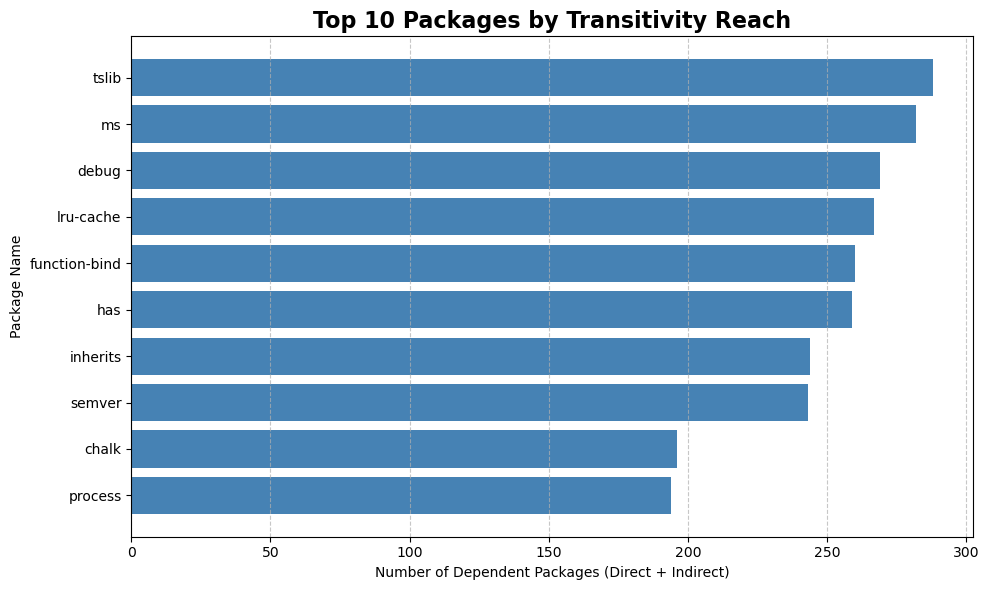

In [7]:
# ----------------------------------------------------
# Step 4: Visualize Top 10 Packages by Transitivity Reach
# ----------------------------------------------------
top10 = reach_df.head(10)

plt.figure(figsize=(10,6))
plt.barh(top10["package"], top10["transitivity_reach"], color="steelblue")
plt.title("Top 10 Packages by Transitivity Reach", fontsize=16, fontweight="bold")
plt.xlabel("Number of Dependent Packages (Direct + Indirect)")
plt.ylabel("Package Name")
plt.gca().invert_yaxis()
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


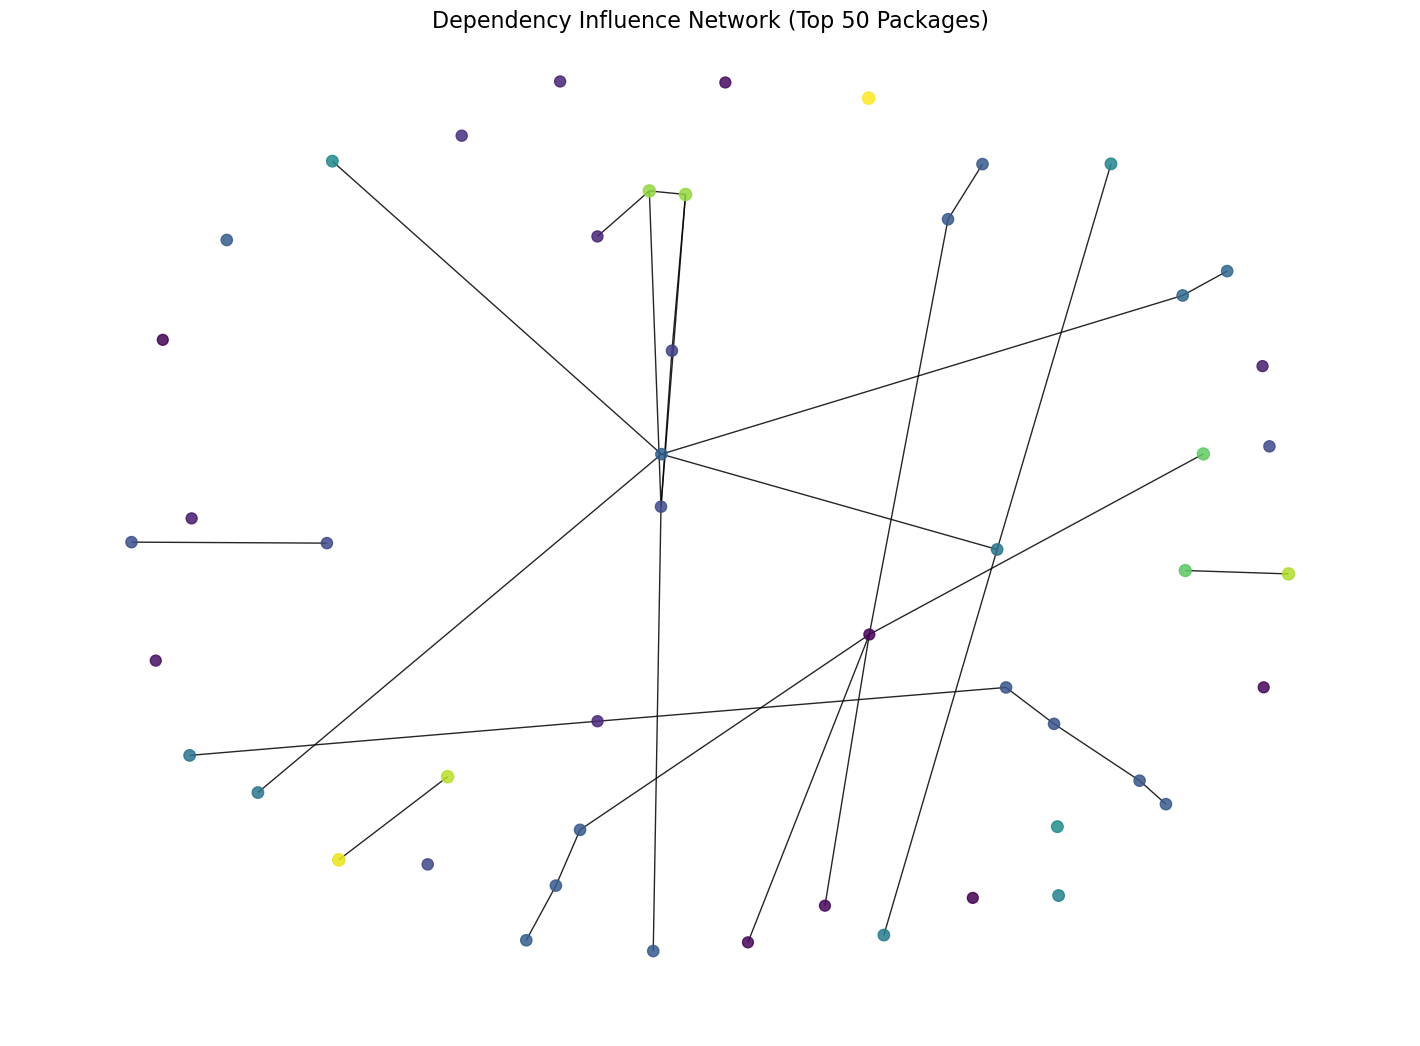

In [9]:
# ----------------------------------------------------
# Step 5: Dependency Influence Network (Top 50 Packages)
# ----------------------------------------------------
top50 = reach_df.head(50)["package"].tolist()
subG = G.subgraph(top50)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(subG, seed=42)
sizes = [G.nodes[n]["transitivity_reach"] / 10 + 50 for n in subG.nodes()]
colors = [G.nodes[n]["transitivity_reach"] for n in subG.nodes()]

nx.draw(
    subG, pos,
    with_labels=False,
    node_size=sizes,
    node_color=colors,
    cmap=plt.cm.viridis,
    alpha=0.85,
    arrows=False
)

plt.title("Dependency Influence Network (Top 50 Packages)", fontsize=16)
plt.show()


In [11]:
# ----------------------------------------------------
# Step 6: Save results
# ----------------------------------------------------
output_path = "/Users/chiaramarzovilla/Downloads/transitivity_reach_results.csv"
reach_df.to_csv(output_path, index=False)
print("✅ Results saved to:", output_path)


✅ Results saved to: /Users/chiaramarzovilla/Downloads/transitivity_reach_results.csv
